#Mount and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Wed Oct 27 14:43:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers==4.2.1
!pip install farasapy
!pip install pyarabic
!pip install sentencepiece
!git clone https://github.com/aub-mind/arabert
!git clone https://github.com/iR00i/JUST-Arabic-Propaganda.git

     |████████████████████████████████| 1.8 MB 7.5 MB/s 
     |████████████████████████████████| 895 kB 43.1 MB/s 
     |████████████████████████████████| 2.9 MB 47.9 MB/s 
     |████████████████████████████████| 126 kB 7.7 MB/s 
     |████████████████████████████████| 1.2 MB 7.2 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 552, done.
remote: Counting objects: 100% (338/338), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 552 (delta 180), reused 239 (delta 89), pack-reused 214
Receiving objects: 100% (552/552), 9.15 MiB | 21.26 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Cloning into 'JUST-Arabic-Propaganda'...
remote: Enumerating objects: 1462, done.
remote: Counting objects: 100% (1462/1462), done.
remote: Compressing objects: 100% (1379/1379), done.
remote: Total 1462 (delta 16), reused 1454 (delta 11), pack-reused 0
Receiving objects: 100% (1462/1462), 2.56 MiB | 17.68 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [4]:
import pandas as pd
import numpy as np
import re

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from arabert.preprocess import ArabertPreprocessor
import transformers
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.metrics import confusion_matrix
%matplotlib inline

#Pandas Viewing presets

In [ ]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.max_rows', None)
# pd.options.display.max_colwidth = 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
pd.reset_option('^display.', silent=True)

#Data Exploration

In [ ]:
arabic_train = pd.read_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Arabic-Data/Train.txt',sep='\t')
arabic_dev = pd.read_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Arabic-Data/Dev.txt',sep='\t')
arabic_test = pd.read_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Arabic-Data/Test.txt',sep='\t')

In [ ]:
path = r'/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Translated-data/'
train = pd.read_csv(path+'train.csv')
dev = pd.read_csv(path+'dev.csv')

In [ ]:
# Get the max_len/ avg_len of the tokenized corpus.
texts = arabic_train.Arabic.values
x = TOKENIZER.batch_encode_plus(texts)['input_ids']
max_len = 0
sum = 0
for i in x:
  sum+=len(i)
  if len(i) > max_len:
    max_len = len(i)
print(f"max_len: {max_len}, average_len: {sum/len(x)}")

In [ ]:
def get_lengths_and_word_count(df, words = False):
  get
  labels = list(df.label.unique())
  dict_labels_char_count = {}
  dict_labels_count = dict.fromkeys(labels, 0)
  for row in df.itertuples():
    label = row.label
    if label in dict_labels_char_count:
      if words:
        dict_labels_char_count[label] += len(row.Arabic.split())
      else:
        dict_labels_char_count[label] += len(row.Arabic)
    else:
      if words:
        dict_labels_char_count[label] = len(row.Arabic.split())
      else:
        dict_labels_char_count[label] = len(row.Arabic)

    dict_labels_count[label] +=1

  for key, value in enumerate(dict_labels_char_count):
    dict_labels_char_count[value] = dict_labels_char_count[value]/dict_labels_count[value]
    
  return dict_labels_char_count

get_lengths_and_word_count(dataset, words=True)

In [ ]:
get_lengths_and_word_count(dataset)

{'Appeal_to_Authority': 108.30379746835443,
 'Appeal_to_fear-prejudice': 76.46153846153847,
 'Bandwagon,Reductio_ad_hitlerum': 83.01298701298701,
 'Black-and-White_Fallacy': 77.89922480620154,
 'Causal_Oversimplification': 98.52422907488987,
 'Doubt': 101.78890876565295,
 'Exaggeration,Minimisation': 36.41760299625468,
 'Flag-Waving': 49.620253164556964,
 'Loaded_Language': 18.33251633986928,
 'Name_Calling,Labeling': 22.07010475423046,
 'Repetition': 14.033942558746736,
 'Slogans': 20.5207100591716,
 'Thought-terminating_Cliches': 27.666666666666668,
 'Whataboutism,Straw_Men,Red_Herring': 80.95588235294117}

In [ ]:
temp

{'Appeal_to_Authority': 0,
 'Appeal_to_fear-prejudice': 0,
 'Bandwagon,Reductio_ad_hitlerum': 0,
 'Black-and-White_Fallacy': 0,
 'Causal_Oversimplification': 0,
 'Doubt': 0,
 'Exaggeration,Minimisation': 0,
 'Flag-Waving': 0,
 'Loaded_Language': 0,
 'Name_Calling,Labeling': 0,
 'Repetition': 0,
 'Slogans': 0,
 'Thought-terminating_Cliches': 0,
 'Whataboutism,Straw_Men,Red_Herring': 0}

In [ ]:
list(train.label.unique())

['Loaded_Language',
 'Name_Calling,Labeling',
 'Doubt',
 'Black-and-White_Fallacy',
 'Slogans',
 'Appeal_to_Authority',
 'Flag-Waving',
 'Repetition',
 'Whataboutism,Straw_Men,Red_Herring',
 'Bandwagon,Reductio_ad_hitlerum',
 'Exaggeration,Minimisation',
 'Appeal_to_fear-prejudice',
 'Thought-terminating_Cliches',
 'Causal_Oversimplification']

In [ ]:
"""
Using the original ptc-corpus for propaganda to translate to arabic.
This code is meant to get the seperate articles with their labels and join them
into a single dataframe. 
"""
from os import listdir
from os.path import isfile, join

def get_file_names_in_dir(mypath):
  return [f for f in listdir(mypath) if isfile(join(mypath, f))]

def get_data(text_path, label_path, test=False):

  df = pd.DataFrame(columns=['id','text'])
  files = get_file_names_in_dir(text_path)
  for idx, f in tqdm(enumerate(files),total=len(files), desc = 'getting text...'):
    txt = Path(text_path+'/'+f).read_text()
    # txt = txt.replace('\n', '')
    id = re.findall('\d+', f)[0]
    df = df.append({'id':id,'text':txt}, ignore_index=True)
  df.sort_values(by = ['id'],inplace=True)
  if test:
    return df
  main_df = pd.DataFrame(columns = ['id', 'text_span', 'label'])
  files = get_file_names_in_dir(label_path)
  for idx, f in tqdm(enumerate(files), total = len(files), desc = 'attaching labels to text'): #looping over the label files
    temp_df = pd.read_csv(label_path+'/'+f, sep = '\t',  names = ['id','prop','start','end'])
    for idx, row in temp_df.iterrows(): #looping over a single label file
      id = str(row['id'])
      text = df.loc[df['id'] == id].text.values[0][row['start']:row['end']]
      label = row['prop']
      main_df = main_df.append(
          {'id':id, 'text_span':text, 'label':label},
          ignore_index=True,
      )
  return main_df


# label_path = '/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/train-labels-task-flc-tc/'
# text_path = '/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/train-articles'
# train = get_data(text_path=text_path, label_path=label_path)

# label_path = '/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/dev-labels-task-flc-tc'
# text_path = '/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/dev-articles'
# dev = get_data(text_path=text_path, label_path=label_path)

# train.to_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/Processed/train.csv',index=False)
# dev.to_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/Processed/dev.csv',index=False)

#Utility

##Dataset class and functions

In [7]:
class Dataset:
  """
  Class Dataset used to create an iterable version of the dataset with the
  ability to return the text tokenized upon indexing.

  An object of this class can be treated as a list object. Indexing with this 
  object (ex: dataset[idx] ) will return a dictionary. 
  """
  def __init__(self, text, target, tokenizer):
    self.text = text
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = config['MAX_LEN']

  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    text = " ".join(text.split())

    inputs = self.tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        truncation='longest_first'
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs['token_type_ids']

    return {
        "ids": torch.tensor(ids, dtype=torch.long),
        "mask": torch.tensor(mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "targets": torch.tensor(self.target[item], dtype=torch.float),
    }

In [8]:
def loss_fn(outputs, targets):
  """ 
  Loss function to claculate loss. Loss measure used is the Binary-Cross-
  Entropy.
  """
  return nn.BCEWithLogitsLoss()(outputs, targets)

def train_fn(data_loader, model, optimizer, device, scheduler):
  """
  Training function. Accepts a torch.dataLoader object, the model to be trained,
  the optimizer, the device to be trained on (ex: Cuda) and finally a scheduler
  for the optimizer.

  The dataLoader is used to iterate over the batches of the training data.
  Performs forward and backprop on the model and saves the weights.
  """
  model.train()

  for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
    ids = d["ids"]
    token_type_ids = d["token_type_ids"]
    mask = d["mask"]
    targets = d["targets"]

    ids = ids.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.float)

    optimizer.zero_grad()
    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    scheduler.step()

def eval_fn(data_loader, model, device):
  """
  Similar to the training function but the model is in evaluation mode (model 
  layers are frozen).

  Performs forward-prop on the model with the validation data.
  Returns the model predictions as well as the data gold labels.
  """
  model.eval()
  fin_targets = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      ids = d["ids"]
      token_type_ids = d["token_type_ids"]
      mask = d["mask"]
      targets = d["targets"]

      ids = ids.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.float)

      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(F.softmax(outputs, dim = 1).cpu().detach().numpy().tolist())
  return fin_outputs, fin_targets

##Preprocessing Code

In [9]:
# """
# Old code.
# """

# def MapLabels(df):
#   """
#   Function to preprocess data.
#   Removes unwanted datasamples according to specific labels.
#   Creates a one-hot-encoded version of the labels. 
#   """
#   onehot_col = []
#   df.drop(df.loc[df['label']=='Repetition'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Bandwagon'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Straw_Men'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Whataboutism'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Reductio_ad_hitlerum'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Red_Herring'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Obfuscation,Intentional_Vagueness,Confusion'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Thought-terminating_Cliches'].index, inplace=True)

#   map = {
#       'Slogans':0,
#       'Black-and-White_Fallacy':1,
#       'Loaded_Language':2,
#       'Flag-Waving':3,
#       'Name_Calling':4,
#       'Labeling':5,
#       'Causal_Oversimplification':6,
#       'Exaggeration':7,
#       'Minimisation':8,
#       'Doubt':9,
#       'Appeal_to_Authority':10,
#       'Appeal_to_fear-prejudice':11,
#   }

#   for idx,row in df.iterrows():
#     temp = re.split(',',df.label[idx])
#     label = []
#     onehot = [0] * 12
#     for l in temp:
#       label.append(map[l])
#     for i in label:
#       onehot[i] = 1
#     onehot_col.append(onehot) 
#   df['oneHot'] = onehot_col
#   return df

In [10]:
def MapLabels(df):
  """
  Function to preprocess data.
  Creates a one-hot-encoded version of the labels. 
  """
  onehot_col = []
  map = {
      'Appeal_to_Authority':0,
      'Appeal_to_fear-prejudice':1,
      'Bandwagon,Reductio_ad_hitlerum':2,
      'Black-and-White_Fallacy':3,
      'Causal_Oversimplification':4,
      'Doubt':5,
      'Exaggeration,Minimisation':6,
      'Flag-Waving':7,
      'Loaded_Language':8,
      'Name_Calling,Labeling':9,
      'Repetition':10,
      'Slogans':11,
      'Thought-terminating_Cliches':12,
      'Whataboutism,Straw_Men,Red_Herring':13
  }

  for idx,row in df.iterrows():
    temp = [0] * 14
    label = row['label']
    temp[map[label]] = 1
    onehot_col.append(temp)
  
  df['onehot'] = onehot_col
  return df

def train_valid_test_split(dataset, target_col_name):
  """ 
  Function to split a given dataset into train-valid-test.

  dataset: pandas.DataFrame object.
  """
  train_ratio, valid_ratio, test_ratio = config['TRAIN_VALID_TEST_SPLIT']
  train, test = model_selection.train_test_split(dataset, test_size = 1 - train_ratio, shuffle=True, stratify = dataset[target_col_name].values)
  valid, test = model_selection.train_test_split(test, test_size = test_ratio/(test_ratio + valid_ratio), stratify = test[target_col_name].values)

  return train, valid, test

##Trainer Code

In [11]:
def Run(train, valid, text_col_name):
  """
  Main runner code to finetune model. Saves model weights on each epoch if the 
  model score is higher than before.
  """

  train = MapLabels(train)
  valid = MapLabels(valid)

  train = train.sample(frac=1).reset_index(drop=True)
  if config['ArabertPreprocessor']:
    print("Using the Arabert Pre-processor")
    arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
    train[text_col_name] = train[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    valid[text_col_name] = valid[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
  else:
    print("Not using the Arabert Pre-processor")

  train_dataset = Dataset(
      text=train[text_col_name].values,
      target=train['onehot'].values,
      tokenizer = TOKENIZER
  )

  train_data_loader = DataLoader(
      train_dataset, batch_size=config['TRAIN_BATCH_SIZE'], num_workers=2
  )

  valid_dataset = Dataset(
      text=valid[text_col_name].values,
      target=valid['onehot'].values,
      tokenizer = TOKENIZER
  )

  valid_data_loader = DataLoader(
      valid_dataset, batch_size=config['VALID_BATCH_SIZE'], num_workers=1
  )

  device = torch.device(config['DEVICE'])
  model = Model()
  model.to(device)

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train) / config['TRAIN_BATCH_SIZE'] * config['EPOCHS'])
  optimizer = AdamW(optimizer_parameters, lr=config['LEARNING_RATE'])
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
  )

  best_score = 0
  performance = []
  for epoch in range(config['EPOCHS']):
    train_fn(train_data_loader, model, optimizer, device, scheduler)
    outputs, targets = eval_fn(valid_data_loader, model, device)
    outputs = np.array(outputs) >= 0.5
    f1_samples = metrics.f1_score(targets, outputs,average='samples')
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    f1_macro = metrics.f1_score(targets, outputs,average='macro')
    accuracy = metrics.accuracy_score(targets, outputs)
    print(f"<---------------Epoch {epoch+1}--------------->")
    print(f"f1-Samples Score = {f1_samples}")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"f1-Macro Score = {f1_macro}")
    print(f"Accuracy Score = {accuracy}")
    epoch_performance = {'Epoch': epoch,
                         'F1-Samples':f1_samples,
                         'F1-Micro':f1_micro,
                         'F1-Macro':f1_macro,
                         'Accuracy':accuracy}
    performance.append(epoch_performance)
    if f1_micro > best_score:
      print("Saving model...")
      torch.save(model.state_dict(), config['MODEL_PATH'])
      best_score = f1_micro
  
  target_names = [
      'Appeal_to_Authority',
      'Appeal_to_fear-prejudice',
      'Bandwagon,Reductio_ad_hitlerum',
      'Black-and-White_Fallacy',
      'Causal_Oversimplification',
      'Doubt',
      'Exaggeration,Minimisation',
      'Flag-Waving',
      'Loaded_Language',
      'Name_Calling,Labeling',
      'Repetition',
      'Slogans',
      'Thought-terminating_Cliches',
      'Whataboutism,Straw_Men,Red_Herring']
  print(metrics.classification_report(targets,outputs,target_names=target_names))

  del model
  return performance

##Evaluation Code

In [12]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
  """
  Function to print confusion matrix for labels.
  """
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  axes.set_ylabel('True label')
  axes.set_xlabel('Predicted label')
  axes.set_title(class_label)

In [13]:
def TuneLearningRate(model_name, train, dev, test, text_col_name, low_lr=1e-5, high_lr=9e-3, epochs=5):
  path = f"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Tuning/"
  train = MapLabels(train)
  dev = MapLabels(dev)
  test = MapLabels(test)
  print(f"Model: {config['MODEL_ID']}")
  if config['ArabertPreprocessor']:
    print("Using the Arabert Pre-processor")
    arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
    train[text_col_name] = train[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    dev[text_col_name] = dev[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    test[text_col_name] = test[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
  else:
    print("Not using the Arabert Pre-processor")

  train_dataset = Dataset(
      text=train[text_col_name].values,
      target=train['onehot'].values,
      tokenizer = TOKENIZER
  )

  train_data_loader = DataLoader(
      train_dataset, batch_size=config['TRAIN_BATCH_SIZE'], num_workers=2
  )

  valid_dataset = Dataset(
      text=dev[text_col_name].values,
      target=dev['onehot'].values,
      tokenizer = TOKENIZER
  )

  valid_data_loader = DataLoader(
      valid_dataset, batch_size=config['VALID_BATCH_SIZE'], num_workers=1
  )

  test_dataset = Dataset(
      text=test['Arabic'].values,
      target=test['onehot'].values,
      tokenizer = TOKENIZER
  )

  test_data_loader = DataLoader(
      test_dataset, batch_size=1, num_workers=1
  )

  global_score = 0
  best_lr = 0
  device = torch.device(config['DEVICE'])
  performance_for_lrs = []
  lr = 1
  decimal = low_lr
  
  while (lr * decimal) < high_lr:
    current_learning_rate = lr * decimal
    lr+=1
    if lr == 10:
      decimal *= 10
      lr = 1
    
    model = Model()
    model.to(device)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    num_train_steps = int(len(train) / config['TRAIN_BATCH_SIZE'] * epochs)
    optimizer = AdamW(optimizer_parameters, lr=current_learning_rate)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )
    best_score = 0
    print("##################################################")
    print("##################################################\n")
    for epoch in range(epochs):
      train_fn(train_data_loader, model, optimizer, device, scheduler)
      outputs, targets = eval_fn(valid_data_loader, model, device)
      outputs = np.array(outputs) >= 0.5
      f1_micro = metrics.f1_score(targets, outputs,average='micro')
      accuracy = metrics.accuracy_score(targets, outputs)

      print(f"<---------------Epoch {epoch+1}--------------->")
      print(f"f1-Micro Score = {f1_micro}")
      print(f"Accuracy Score = {accuracy}")

      if f1_micro > best_score:
        best_score = f1_micro
        print("Saving model...")
        torch.save(model.state_dict(), path+f'{model_name}.bin')
    
    model.load_state_dict(torch.load(path+f'{model_name}.bin'))
    outputs, targets = eval_fn(test_data_loader, model, device)
    outputs = np.array(outputs) >= 0.5
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    accuracy = metrics.accuracy_score(targets, outputs)
    
    print(f"\n<---------------Test Set Performance--------------->")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"Accuracy Score = {accuracy}")
    print(f"Current lr: {current_learning_rate}")
    print(f"Local_Score on training data: {best_score}")
    temp_dict = {
        'learning_rate':current_learning_rate,
        'Accuracy':accuracy,
        'f1-micro':f1_micro,
    }
    performance_for_lrs.append(temp_dict)
    if f1_micro > global_score:
      print(f"\nChanging global score...")
      print(f"Old Global score: {global_score} with lr={current_learning_rate}")
      global_score = f1_micro
      best_lr = current_learning_rate
      print(f"Global score now: {global_score}, lr={best_lr}")
      print("Saving model...")
      torch.save(model.state_dict(), path+f'{model_name}_final_model.bin')
      best_score = f1_micro
    del model
    print('\n\n')
  
  print(f"\nGlobal_score: {global_score}")
  print(f"Best lr: {best_lr}")

  temp_dict = {
      'Best_LEARNING_RATE':best_lr,
      'Score':global_score,
  }
  performance_for_lrs.append(temp_dict)
  return performance_for_lrs

##Model Class

In [14]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(config['MODEL_ID'], return_dict=False)
        
        self.bert_drop = nn.Dropout(0.0)
        self.out = nn.Linear(config['HIDDEN_SIZE'], config['NUM_LABELS'])

    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

#Config

In [15]:
"""
aubmindlab/bert-base-arabertv02
asafaya/bert-base-arabic
kuisailab/albert-base-arabic
UBC-NLP/ARBERT
UBC-NLP/MARBERT
"""

config = {
    'MODEL_ID': "aubmindlab/bert-base-arabertv02",
    'HIDDEN_SIZE': 768,
    'DEVICE': "cuda",
    'MAX_LEN': 200,

    'TRAIN_BATCH_SIZE': 32,
    'VALID_BATCH_SIZE': 16,
    'TRAIN_VALID_TEST_SPLIT':(0.8, 0.1, 0.1), # train-valid-test: 0.8-0.1-0.1

    'EPOCHS': 10,
    'LEARNING_RATE': 8e-5,

    'MODEL_PATH': "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/model.bin",
    'NUM_LABELS': 14,
    'ArabertPreprocessor': True,
  }
performance = {}
TOKENIZER = transformers.BertTokenizer.from_pretrained(config['MODEL_ID'])

Downloading:   0%|          | 0.00/825k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

In [16]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
train = pd.read_csv(path+'train.csv')
valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

#Training Code

In [17]:
model_performance = Run(train, valid, text_col_name='Arabic')
performance['MODEL_EPOCHS'] = model_performance

with open('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/config.json', 'w') as fp:
    json.dump(config, fp)
with open('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Epochs.json', 'w') as fp:
    json.dump(performance, fp)

Using the Arabert Pre-processor


Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Samples Score = 0.38803894297635605
f1-Micro Score = 0.5004484304932736
f1-Macro Score = 0.11676735254541377
Accuracy Score = 0.38803894297635605
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Samples Score = 0.5034770514603616
f1-Micro Score = 0.5696302124311565
f1-Macro Score = 0.2897554544348761
Accuracy Score = 0.5034770514603616
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Samples Score = 0.5396383866481224
f1-Micro Score = 0.5901140684410646
f1-Macro Score = 0.384222438066244
Accuracy Score = 0.5396383866481224
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Samples Score = 0.5660639777468707
f1-Micro Score = 0.6016260162601625
f1-Macro Score = 0.40453364231687167
Accuracy Score = 0.5660639777468707
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Samples Score = 0.6175243393602226
f1-Micro Score = 0.6458181818181818
f1-Macro Score = 0.507594393645083
Accuracy Score = 0.6175243393602226
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Samples Score = 0.5924895688456189
f1-Micro Score = 0.6209912536443148
f1-Macro Score = 0.48564962283587215
Accuracy Score = 0.5924895688456189


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Samples Score = 0.6161335187760779
f1-Micro Score = 0.6310541310541311
f1-Macro Score = 0.5155089549451878
Accuracy Score = 0.6161335187760779


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Samples Score = 0.6230876216968011
f1-Micro Score = 0.6336633663366337
f1-Macro Score = 0.49826916557514117
Accuracy Score = 0.6230876216968011


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Samples Score = 0.6203059805285118
f1-Micro Score = 0.6303886925795052
f1-Macro Score = 0.48960262497171614
Accuracy Score = 0.6203059805285118


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Samples Score = 0.6230876216968011
f1-Micro Score = 0.6386315039201711
f1-Macro Score = 0.5103765566706987
Accuracy Score = 0.6230876216968011
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.43      0.38      0.40        16
          Appeal_to_fear-prejudice       0.53      0.47      0.50        34
    Bandwagon,Reductio_ad_hitlerum       0.40      0.25      0.31         8
           Black-and-White_Fallacy       0.36      0.38      0.37        13
         Causal_Oversimplification       0.65      0.50      0.56        22
                             Doubt       0.67      0.64      0.65        56
         Exaggeration,Minimisation       0.44      0.49      0.46        53
                       Flag-Waving       0.74      0.74      0.74        31
                   Loaded_Language       0.79      0.71      0.75       245
             Name_Calling,Labeling       0.69      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Testing Code

In [18]:
test = MapLabels(test)
if config['ArabertPreprocessor']:
  arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
  test['Arabic'] = test['Arabic'].apply(lambda x:  arabert_prep.preprocess(x))

model = Model()
model.load_state_dict(torch.load(config['MODEL_PATH']))
model.eval()
device = torch.device(config['DEVICE'])
model.to(device)

test_dataset = Dataset(
      text=test['Arabic'].values,
      target=test['onehot'].values,
      tokenizer = TOKENIZER
  )

test_data_loader = DataLoader(
    test_dataset, batch_size=1, num_workers=1
)
outputs, targets = eval_fn(test_data_loader, model, device)
outputs = np.array(outputs) >= 0.5
f1 = metrics.f1_score(targets, outputs,average='samples')
f1_micro = metrics.f1_score(targets, outputs,average='micro')
f1_macro = metrics.f1_score(targets, outputs,average='macro')
accuracy = metrics.accuracy_score(targets, outputs)
print(f"<---------------Test Set Performance--------------->")
print(f"f1-Samples Score = {f1}")
print(f"f1-Micro Score = {f1_micro}")
print(f"f1-Macro Score = {f1_macro}")
print(f"Accuracy Score = {accuracy}")

  0%|          | 0/720 [00:00<?, ?it/s]

<---------------Test Set Performance--------------->
f1-Samples Score = 0.6138888888888889
f1-Micro Score = 0.6438455935906774
f1-Macro Score = 0.45788501150084215
Accuracy Score = 0.6138888888888889


model name:  aubmindlab/bert-base-arabertv02 
Arabert_Prep: True 
Accuracy:  0.6138888888888889

                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.4167    0.3125    0.3571        16
          Appeal_to_fear-prejudice     0.4231    0.3235    0.3667        34
    Bandwagon,Reductio_ad_hitlerum     0.5000    0.1429    0.2222         7
           Black-and-White_Fallacy     0.6667    0.1538    0.2500        13
         Causal_Oversimplification     0.4737    0.3913    0.4286        23
                             Doubt     0.6154    0.5714    0.5926        56
         Exaggeration,Minimisation     0.5000    0.4444    0.4706        54
                       Flag-Waving     0.8182    0.5625    0.6667        32
                   Loaded_Language     0.7224    0.8286    0.7719       245
             Name_Calling,Labeling     0.7094    0.6694    0.6888       124
                        Repetition     0.8958    0.5584    0.6880 

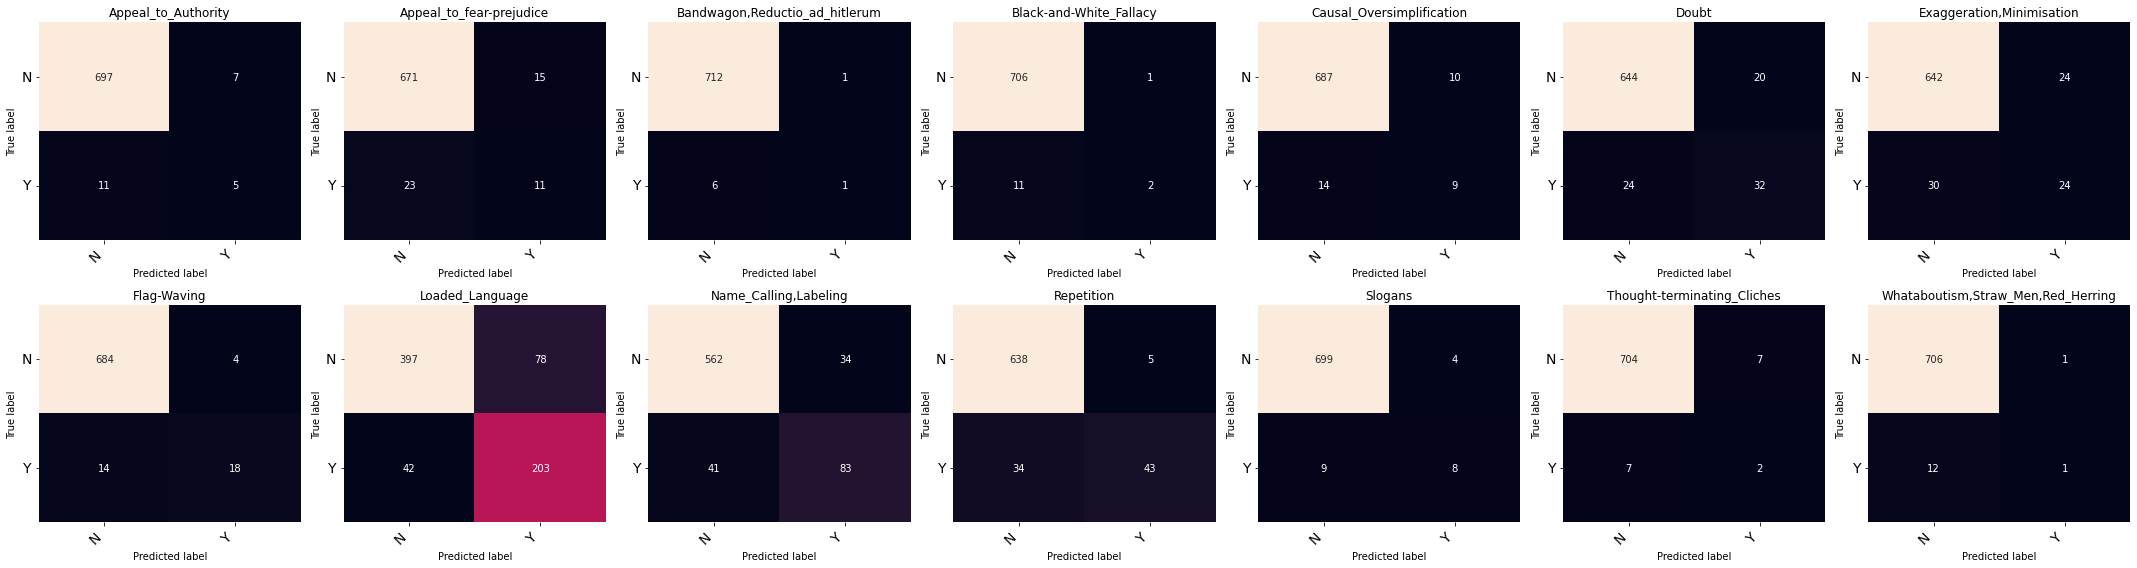

In [19]:
gold_list = targets
preds_list = outputs

target_names = [
      'Appeal_to_Authority',
      'Appeal_to_fear-prejudice',
      'Bandwagon,Reductio_ad_hitlerum',
      'Black-and-White_Fallacy',
      'Causal_Oversimplification',
      'Doubt',
      'Exaggeration,Minimisation',
      'Flag-Waving',
      'Loaded_Language',
      'Name_Calling,Labeling',
      'Repetition',
      'Slogans',
      'Thought-terminating_Cliches',
      'Whataboutism,Straw_Men,Red_Herring']
report = metrics.classification_report(gold_list, preds_list, target_names=target_names,zero_division=0,digits=4)
cm = metrics.multilabel_confusion_matrix(gold_list, preds_list)
accuracy = metrics.accuracy_score(gold_list, preds_list)
print("model name: ",config['MODEL_ID'], '\nArabert_Prep:',config['ArabertPreprocessor'],"\nAccuracy: ", accuracy)

print()
print(report)

rp_dict = metrics.classification_report(gold_list, preds_list, target_names=target_names,zero_division=0, output_dict=True)
config['report'] = rp_dict

fig, ax = plt.subplots(2, 7, figsize=(30, 8))
for axes, cmi, label in zip(ax.flatten(), cm, target_names):
    print_confusion_matrix(cmi, axes, label, ["N", "Y"])
fig.tight_layout()
plt.show()
fig.savefig("/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/output.png")